# Proyecto 1 
Samantha Licea Dominguez

# Actividades (50 pts)

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import openpyxl
import collections
import string

import nltk
nltk.download('stopwords')
from nltk.tokenize import TweetTokenizer
tokenizer = TweetTokenizer()
import itertools
from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from nltk.corpus import stopwords
from datetime import datetime
from collections import OrderedDict

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from scipy.sparse import hstack

stop_words_sp = list(set(stopwords.words('spanish')))
stop_words_en = list(set(stopwords.words('english')))

stwrds = stop_words_sp + stop_words_en

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Análisis Exploratorio (2.5 pts)

El dataset contiene aprox 10,000 opiniones de TripAdvisor de Guanajuato

Task 1

*   Construir estadísticas básicas respecto a la opinión de cada lugar turístico
*   Preprocesar y limpiar el texto



In [5]:
path = 'Opiniones Tripadvisor_nlp_2023.xlsx'

In [6]:
headers = pd.read_excel(path).columns
print(headers)

Index(['Género', 'Edad', 'Nacional ó Internacional', 'Calificación', 'Escala',
       'Número de aportaciones', 'Título de la opinión', 'Opinión', 'País',
       'Idioma', 'Dispositivo', 'Fecha'],
      dtype='object')


In [7]:
workbook = openpyxl.load_workbook(path)
sheets = workbook.sheetnames
print(sheets)

['Basilica Colegiata 560', 'Mercado Hidalgo 600', 'Casa de Diego Rivera 698', 'Universidad de Guanajuato 900', 'Alhóndiga 930', 'Teatro Juárez 1,010', 'Jardín de la Unión 1,134', 'Callejón del Beso 1,360', 'Monumento Pípila 1,620', 'Museo de las Momias 1,650']


In [8]:
genero = {}
naoin = {}
dispositivos = {}
for s in sheets:
  df = pd.DataFrame(pd.read_excel(path,sheet_name=s))
  f = 0
  m = 0
  i = 0
  n = 0
  mov = 0
  pc = 0
  for h in headers:
    if h == 'Género':
      for g in df['Género']:
        if g == 'Femenino':
          f+=1
        else:
          m+=1  
    elif h == 'Nacional ó Internacional':
      for ni in df['Nacional ó Internacional']:
        if ni == 'Nacional':
          n += 1
        else:
          i += 1
    elif h == 'Dispositivo':
      for d in df['Dispositivo']:
        if d == 'Móvil':
          mov += 1
        else:
          pc += 1
  genero.update({s:[f,m]})
  naoin.update({s:[n,i]})  
  dispositivos.update({s:[mov,pc]})

In [9]:
for g in genero.keys():
  print(g,"->",genero[g])

Basilica Colegiata 560 -> [243, 317]
Mercado Hidalgo 600 -> [272, 328]
Casa de Diego Rivera 698 -> [349, 349]
Universidad de Guanajuato 900 -> [416, 484]
Alhóndiga 930 -> [417, 513]
Teatro Juárez 1,010 -> [456, 554]
Jardín de la Unión 1,134 -> [510, 624]
Callejón del Beso 1,360 -> [682, 678]
Monumento Pípila 1,620 -> [743, 877]
Museo de las Momias 1,650 -> [779, 871]


In [10]:
for ni in naoin.keys():
  print(ni,'->',naoin[ni])

Basilica Colegiata 560 -> [276, 284]
Mercado Hidalgo 600 -> [299, 301]
Casa de Diego Rivera 698 -> [270, 428]
Universidad de Guanajuato 900 -> [573, 327]
Alhóndiga 930 -> [630, 300]
Teatro Juárez 1,010 -> [586, 424]
Jardín de la Unión 1,134 -> [572, 562]
Callejón del Beso 1,360 -> [806, 554]
Monumento Pípila 1,620 -> [785, 835]
Museo de las Momias 1,650 -> [842, 808]


### Género por lugar

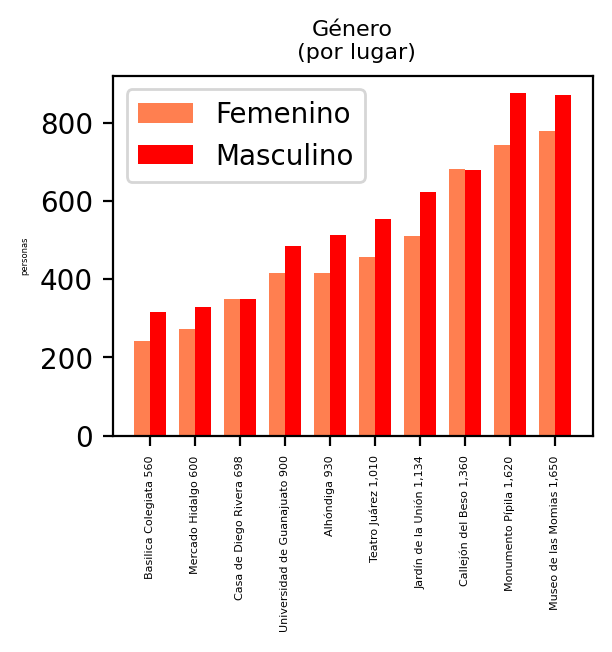

In [11]:
fem = []
mas = []
key = genero.keys()
for k in genero.keys():
  fem.append(genero[k][0])
  mas.append(genero[k][1])
  #print(edades[k][0]," ",edades[k][1])
#print(fem,'->',mas)
fig = plt.figure(figsize=(3,3),dpi=200)
left, bottom, width, height = 0.1, 0.3, 0.8, 0.6
ax = fig.add_axes([left, bottom, width, height]) 

width = 0.35   
ticks = np.arange(len(key))
ax.bar(ticks, fem, width, label='Femenino',color='coral')
ax.bar(ticks + width, mas, width, align="center",label='Masculino',color='red')

ax.set_ylabel('personas',fontsize=3)
ax.set_title('Género\n (por lugar)',fontsize=8)
ax.set_xticks(ticks + width/2)
ax.set_xticklabels(key,rotation=90,fontsize=4)

ax.legend(loc='best')
plt.show()

### Promedios de calificación por lugar, y desviaciones estándar en los scores

In [12]:
scores = {}
st_dev = {}
for s in sheets:
  df = pd.DataFrame(pd.read_excel(path,sheet_name=s))
  for h in headers:
    if h == 'Escala':
      cont = 0
      sum = 0
      for rate in df['Escala']:
        sum += rate
        cont += 1
      avg = np.round(sum/cont,2)
      st = 0
      for rate in df['Escala']:
        st += (rate-avg)**2
      st = st/cont
      st = np.round(np.sqrt(st),2)
      scores.update({s:avg})
      st_dev.update({s:st})

In [13]:
print(scores)
print(st_dev)

{'Basilica Colegiata 560': 4.5, 'Mercado Hidalgo 600': 3.95, 'Casa de Diego Rivera 698': 4.24, 'Universidad de Guanajuato 900': 4.6, 'Alhóndiga 930': 4.45, 'Teatro Juárez 1,010': 4.7, 'Jardín de la Unión 1,134': 4.59, 'Callejón del Beso 1,360': 4.0, 'Monumento Pípila 1,620': 4.38, 'Museo de las Momias 1,650': 3.68}
{'Basilica Colegiata 560': 0.67, 'Mercado Hidalgo 600': 0.95, 'Casa de Diego Rivera 698': 0.8, 'Universidad de Guanajuato 900': 0.61, 'Alhóndiga 930': 0.75, 'Teatro Juárez 1,010': 0.52, 'Jardín de la Unión 1,134': 0.61, 'Callejón del Beso 1,360': 0.97, 'Monumento Pípila 1,620': 0.77, 'Museo de las Momias 1,650': 1.14}


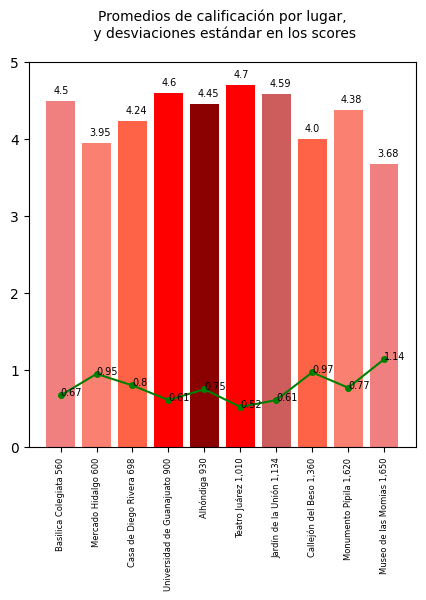

In [14]:
v = list(scores.values())
vst = list(st_dev.values())

fig, ax = plt.subplots(figsize=(5,5))
plt.title('Promedios de calificación por lugar,\n y desviaciones estándar en los scores\n',fontsize=10)
plt.bar(range(len(scores)),v,tick_label=sheets,color=['lightcoral','salmon','tomato','red','darkred','red','indianred','tomato','salmon','lightcoral'])
for i in range(len(v)):
  plt.annotate(str(v[i]),xy=(i-0.2,v[i]+0.1),fontsize=7)
plt.plot(range(len(st_dev)),vst,color='green',marker='o',ms=4)
for i in range(len(vst)):
  plt.annotate(str(vst[i]),xy=(i,vst[i]),fontsize=7)
plt.ylim(0,5)
plt.xticks(rotation=90,fontsize=6)
plt.show()

### Basado en palabras: longitud promedio de opiniones y desviaciones estándar

In [15]:
opiniones = {}
o_st = {}
for s in sheets:
  df = pd.DataFrame(pd.read_excel(path,sheet_name=s))
  for h in headers:
    if h == 'Opinión':
      sum = 0
      cont = 0
      for o in df['Opinión']:
        sum += len(o.split())
        cont += 1
      avg = np.round(sum/cont,2)
      st = 0
      for o in df['Opinión']:
        aux = len(o.split())-avg
        st += (aux)**2
      st = np.round(np.sqrt(st/cont),2)
      opiniones.update({s:avg})
      o_st.update({s:st})

In [16]:
print(opiniones)
print(o_st)

{'Basilica Colegiata 560': 39.72, 'Mercado Hidalgo 600': 45.62, 'Casa de Diego Rivera 698': 49.28, 'Universidad de Guanajuato 900': 35.39, 'Alhóndiga 930': 46.53, 'Teatro Juárez 1,010': 41.5, 'Jardín de la Unión 1,134': 43.14, 'Callejón del Beso 1,360': 45.53, 'Monumento Pípila 1,620': 47.38, 'Museo de las Momias 1,650': 58.23}
{'Basilica Colegiata 560': 29.51, 'Mercado Hidalgo 600': 33.46, 'Casa de Diego Rivera 698': 30.46, 'Universidad de Guanajuato 900': 20.05, 'Alhóndiga 930': 33.96, 'Teatro Juárez 1,010': 27.1, 'Jardín de la Unión 1,134': 37.0, 'Callejón del Beso 1,360': 32.94, 'Monumento Pípila 1,620': 35.91, 'Museo de las Momias 1,650': 46.51}


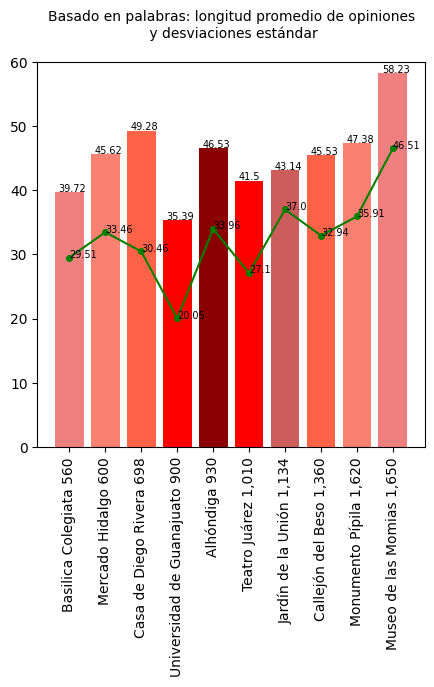

In [17]:
v_p = list(opiniones.values())
vstp = list(o_st.values())

fig, ax = plt.subplots(figsize=(5,5))
plt.title('Basado en palabras: longitud promedio de opiniones\n y desviaciones estándar\n',fontsize=10)
plt.bar(range(len(scores)),v_p,tick_label=sheets,color=['lightcoral','salmon','tomato','red','darkred','red','indianred','tomato','salmon','lightcoral'])
for i in range(len(v_p)):
  plt.annotate(str(v_p[i]),xy=(i-0.3,v_p[i]+0.1),fontsize=7)
plt.plot(range(len(st_dev)),vstp,color='green',marker='o',ms=4)
for i in range(len(vstp)):
  plt.annotate(str(vstp[i]),xy=(i,vstp[i]),fontsize=7)
plt.ylim(0,60)
plt.xticks(rotation=90)
plt.show()

### Tipo de visitantes (nacional o internacional) por lugar

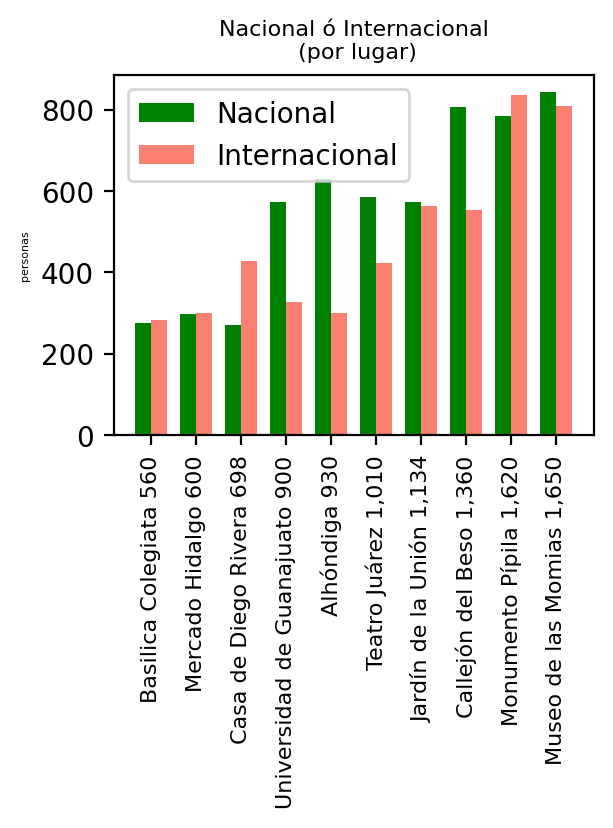

In [18]:
nat = []
inte = []
key = naoin.keys()
for k in naoin.keys():
  nat.append(naoin[k][0])
  inte.append(naoin[k][1])
  #print(edades[k][0]," ",edades[k][1])
#print(nat,'->',inte)

fig = plt.figure(figsize=(3,3),dpi=200)
left, bottom, width, height = 0.1, 0.3, 0.8, 0.6
ax = fig.add_axes([left, bottom, width, height]) 

width = 0.35   
ticks = np.arange(len(key))
ax.bar(ticks, nat, width, label='Nacional',color='green',)
ax.bar(ticks + width, inte, width, align="center",label='Internacional',color='salmon')

ax.set_ylabel('personas',fontsize=4)
ax.set_title('Nacional ó Internacional\n (por lugar)',fontsize=8)
ax.set_xticks(ticks + width/2)
ax.set_xticklabels(key,rotation=90,fontsize=8)

ax.legend(loc='best')
plt.show()

### Edades de opiniones por lugar

In [19]:
edades = {}

for s in sheets:
  df = pd.DataFrame(pd.read_excel(path,sheet_name=s))
  for h in headers:
    if h == 'Edad':
      aux = {}
      for edad in df['Edad']:
        if edad not in aux.keys() and np.isnan(edad) == False:
          aux.update({edad:1})
        elif edad in aux.keys() and np.isnan(edad) == False:
          aux[edad] += 1
      edades.update({s:aux})

In [20]:
def plt_edades(s):
  d = edades[s]
  od = collections.OrderedDict(sorted(d.items()))

  k = list(od.keys())
  v = list(od.values())

  plt.figure(figsize=(8,8))
  plt.title(s)
  plt.bar(range(len(v)),v,tick_label=k,color=['lightcoral','salmon','tomato','red','darkred','red','indianred','tomato','salmon','lightcoral'])
  plt.ylim(0,65)
  plt.xlabel('edades')
  plt.ylabel('numero de personas')
  plt.xticks(rotation=90,fontsize=7)
  plt.show()

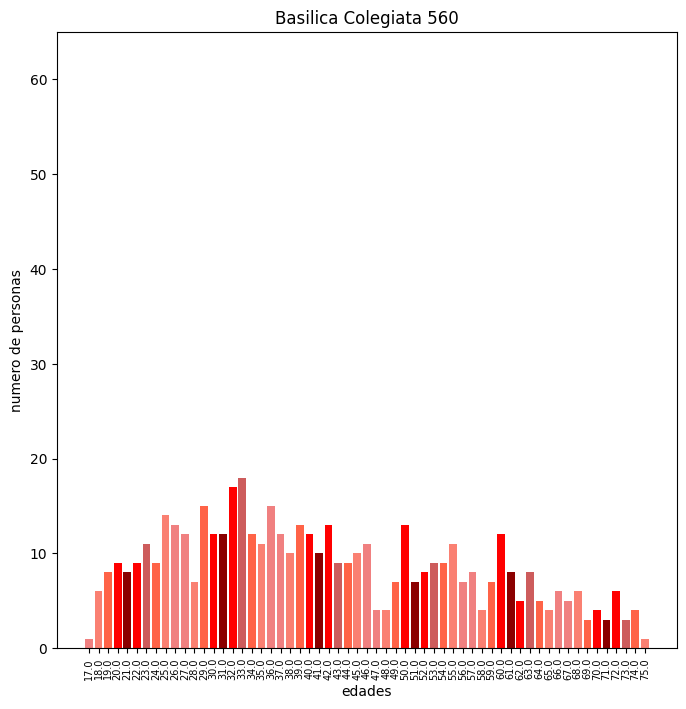

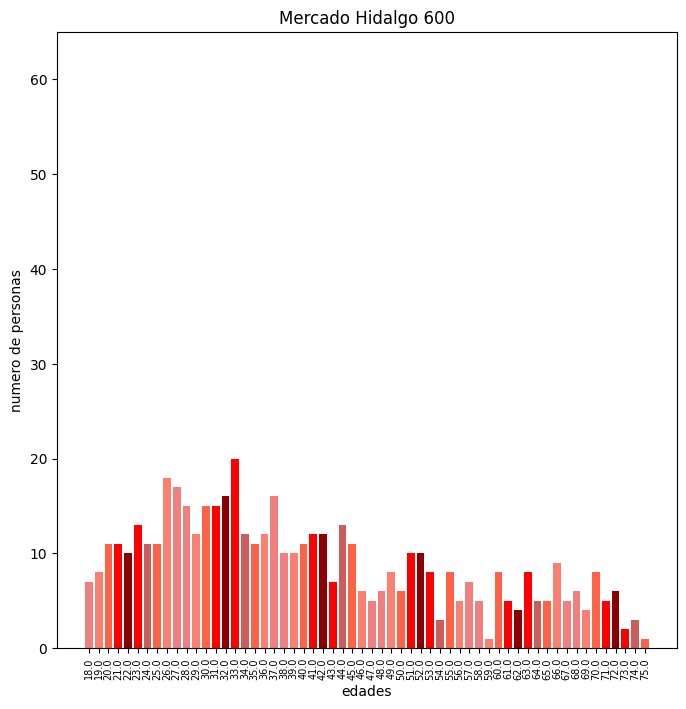

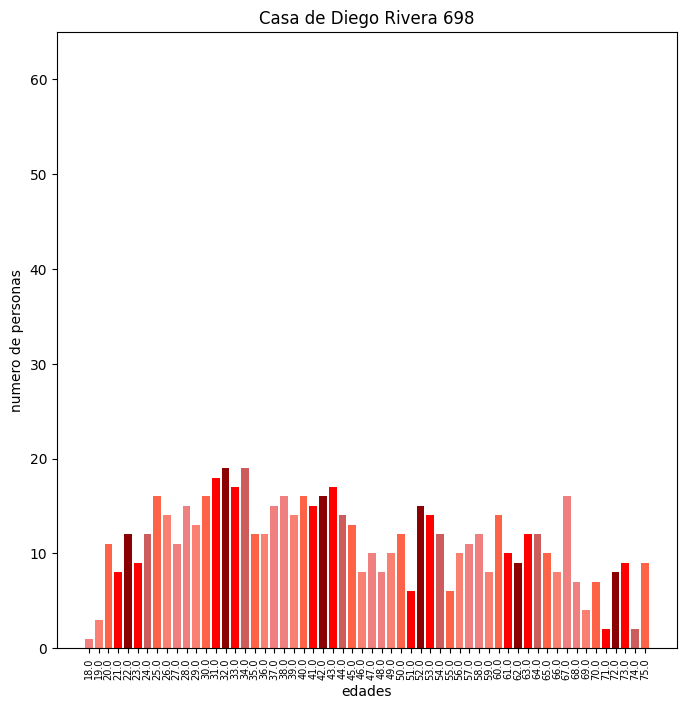

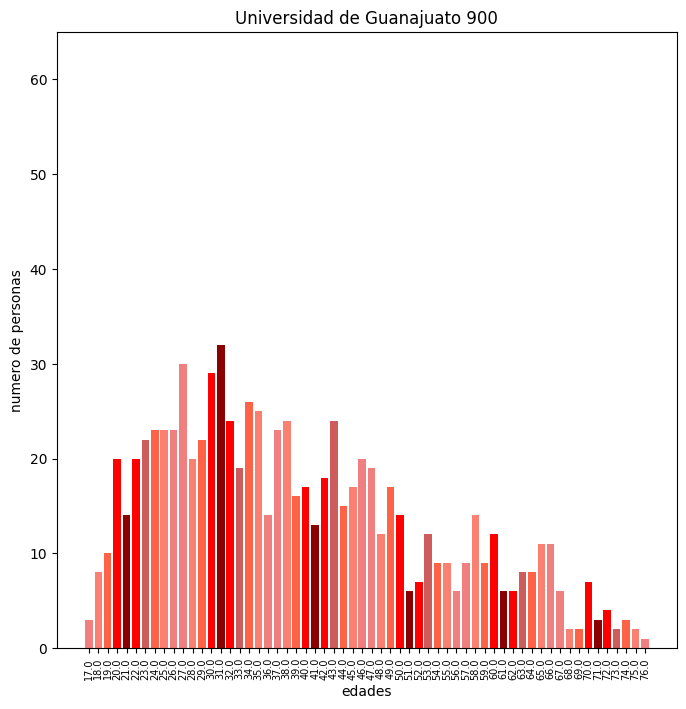

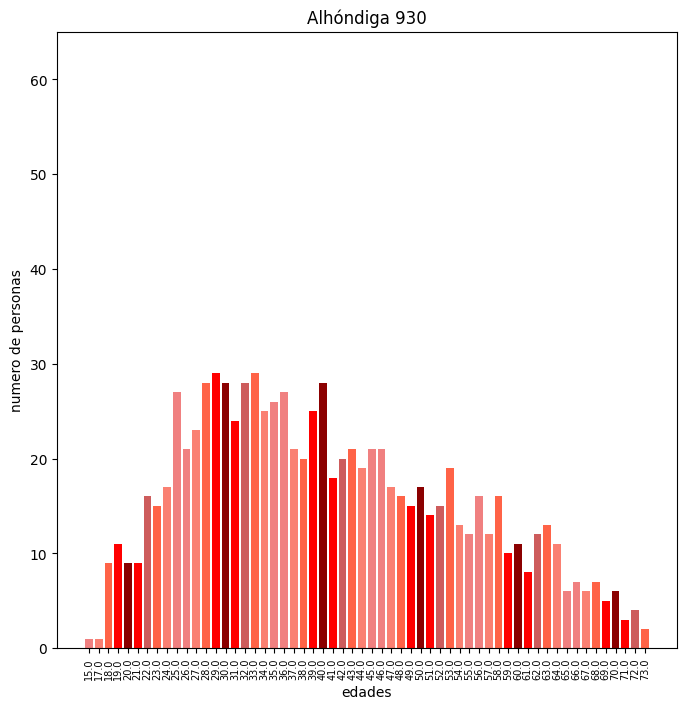

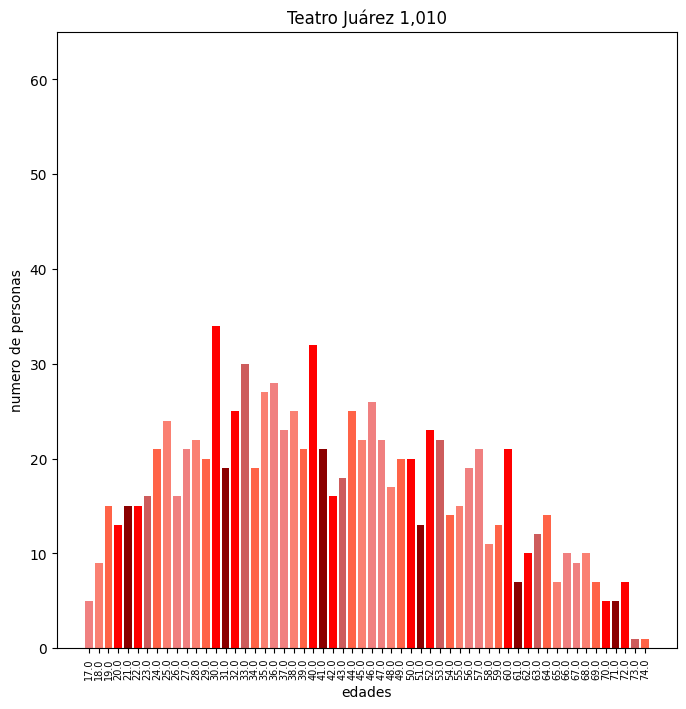

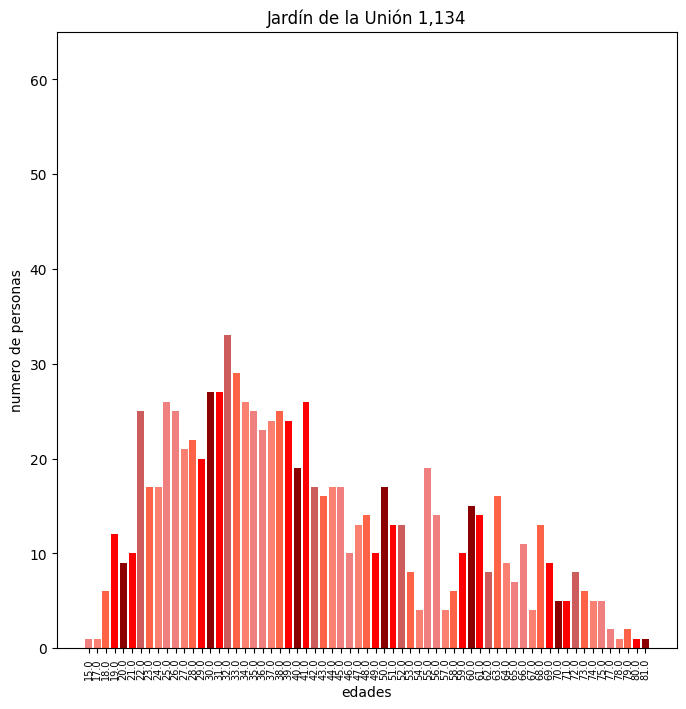

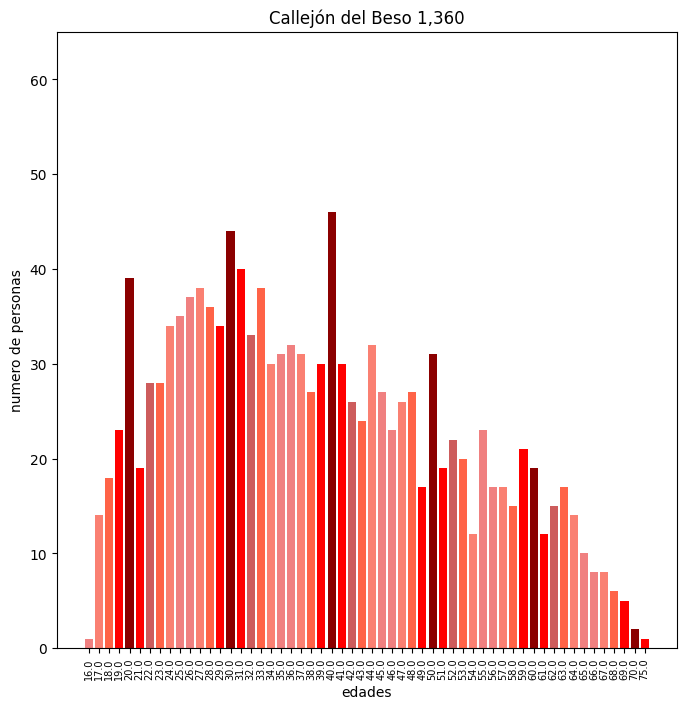

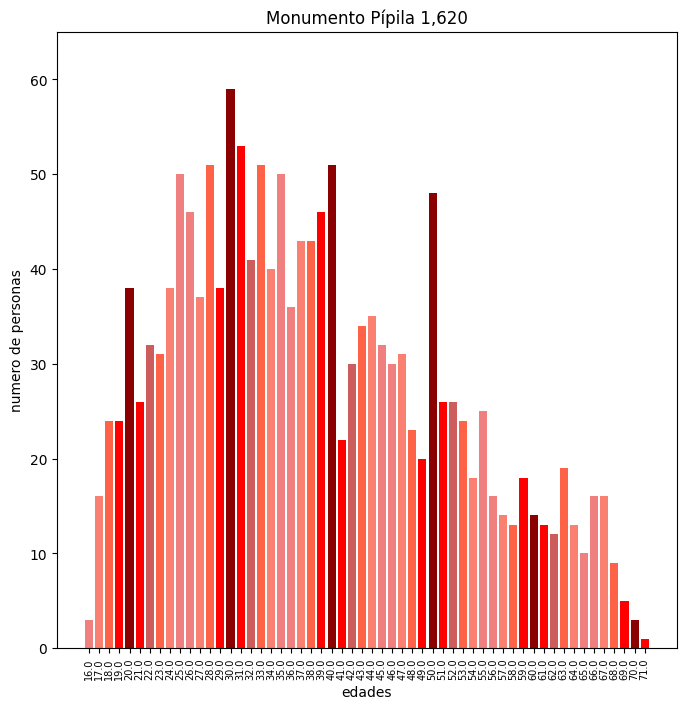

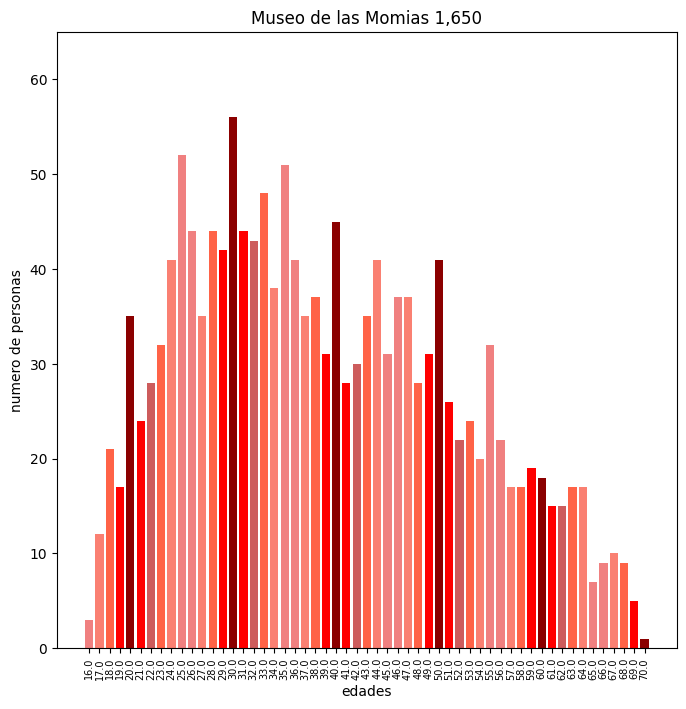

In [21]:
for k in edades.keys():
  plt_edades(k)

### Dispositivos usados para los ratings

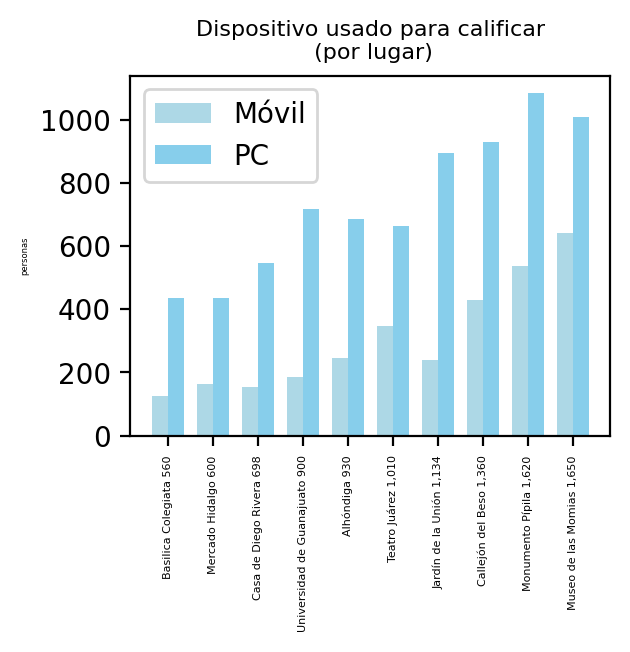

In [22]:
movil = []
compu = []
key = dispositivos.keys()
for k in dispositivos.keys():
  movil.append(dispositivos[k][0])
  compu.append(dispositivos[k][1])
  #print(edades[k][0]," ",edades[k][1])
#print(fem,'->',mas)
fig = plt.figure(figsize=(3,3),dpi=200)
left, bottom, width, height = 0.1, 0.3, 0.8, 0.6
ax = fig.add_axes([left, bottom, width, height]) 

width = 0.35   
ticks = np.arange(len(key))
ax.bar(ticks, movil, width, label='Móvil',color='lightblue')
ax.bar(ticks + width, compu, width, align="center",label='PC',color='skyblue')

ax.set_ylabel('personas',fontsize=3)
ax.set_title('Dispositivo usado para calificar\n (por lugar)',fontsize=8)
ax.set_xticks(ticks + width/2)
ax.set_xticklabels(key,rotation=90,fontsize=4)

ax.legend(loc='best')
plt.show()

# Feature Selection (2.5 pts)
Utilizando una estrategia de feature selection (se sugiere ${x^2}$ o ganancia de información) visualice con word_cloud (https://amueller.github.io/word_cloud/) nubes de palabras el top k (se sugiere 50) de palabras más relevantes para cada uno de los 10 lugares. Note que serán 10 nubes, una por lugar.

In [23]:
!pip install wordcloud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [24]:
#obtenemos las opiniones de cada una de las hojas de excel
def get_ratings():
  #key: nombre de la hoja, value: lista de opiniones
  ratings = {}
  for s in sheets:
    df = pd.DataFrame(pd.read_excel(path,sheet_name=s))
    for h in headers:
      if h == 'Opinión':
        aux = []
        for opinion in df['Opinión']:
          aux.append(opinion)
        ratings.update({s:aux})
  #regresa un diccionario de opiniones
  return ratings

def sortFreqDict(freqdict):
    aux = [(freqdict[key], key) for key in freqdict]
    aux.sort()
    aux.reverse()
    return aux

def obtain(s):
  #recibe el nombre de la hoja
  r = get_ratings()
  #obtenemos la lista de opiniones
  doc = r[s]
  corpus_palabras = []
  #tokenizamos
  for op in doc:
      corpus_palabras += tokenizer.tokenize(op)
  
  fdist = nltk.FreqDist(corpus_palabras)
  V = sortFreqDict(fdist)
  #tomamos el top50 de palabras
  return top50(V)

def top50(v):
  punct = ['.',',',';',':','-','^','>>','!','¡','?','¿','"','\'','...','<url>','*','@usuario']
  t50 = {}
  for freq,string in v:
    #quitamos palabras como de, por, como y puntuacion
    if str(string) not in stwrds and str(string) not in punct and len(string) > 3:
      t50.update({string:freq})
  t50 = dict(itertools.islice(t50.items(), 50))
  return t50

def Nube(top,title):
  wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(top)
  plt.figure(figsize=(8,4))
  plt.title(title)
  plt.imshow(wordcloud)
  plt.axis("off")
  #plt.show()

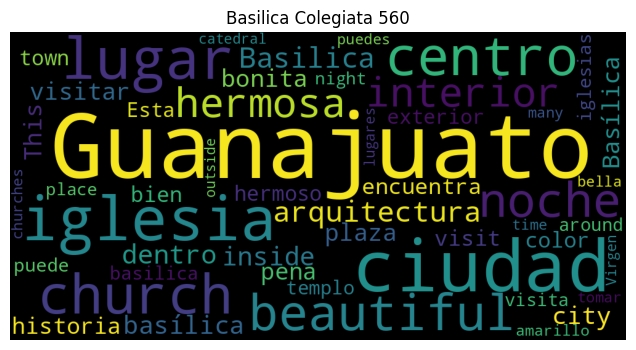

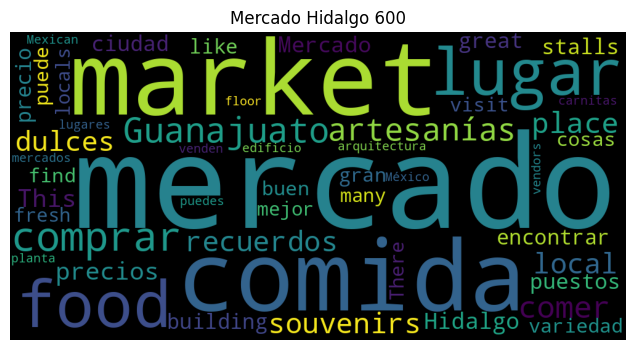

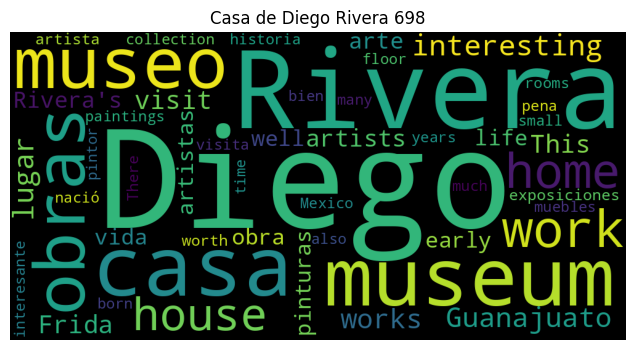

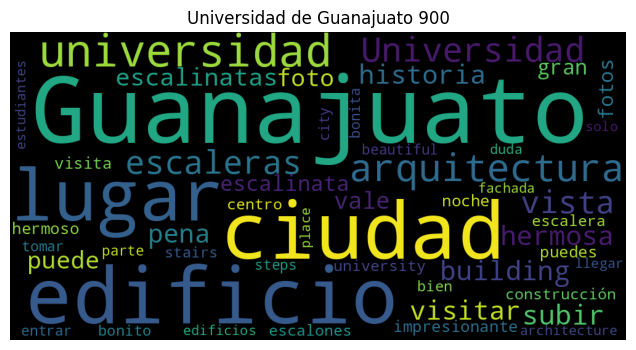

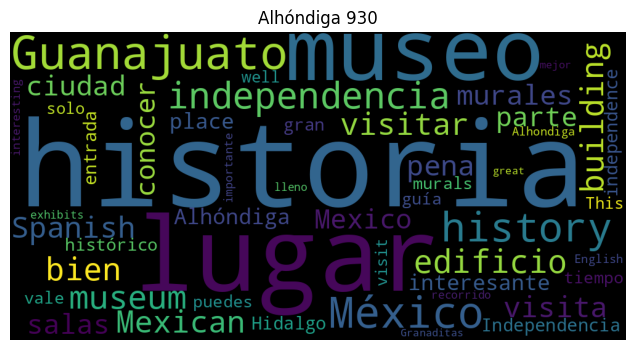

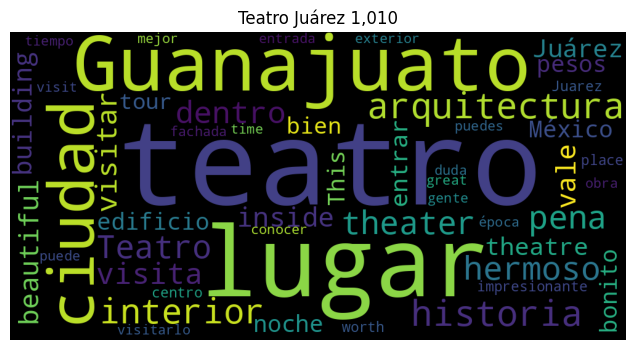

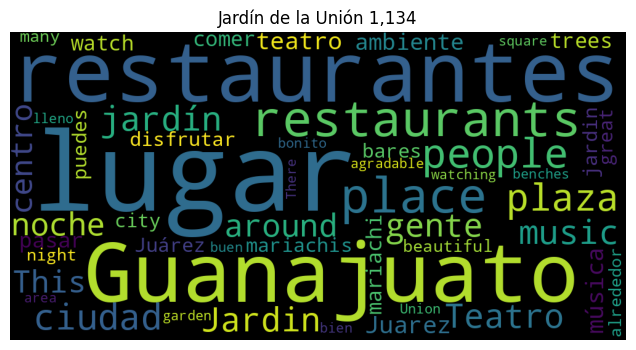

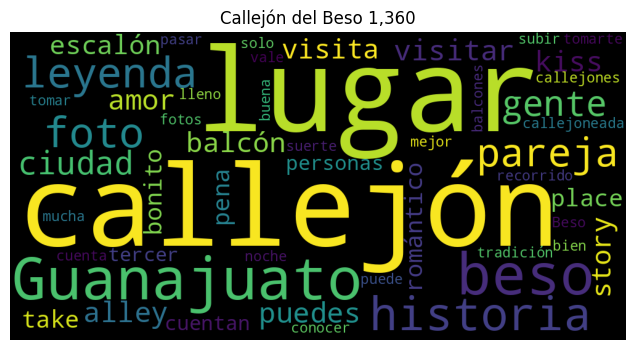

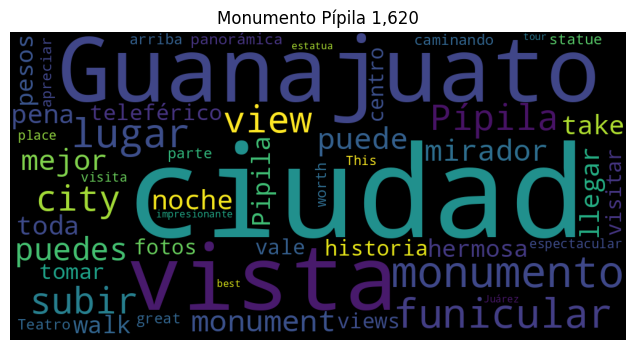

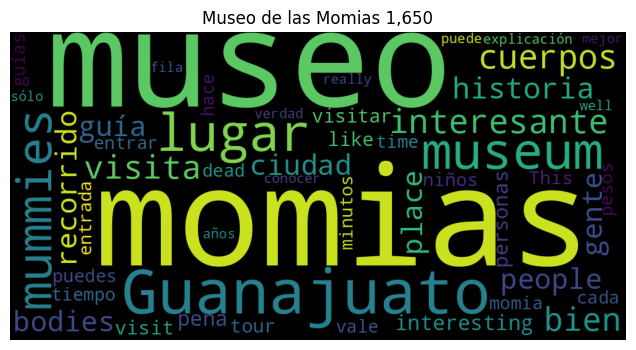

In [25]:
for s in sheets:
  x = obtain(s)
  Nube(x,s)

# LSA (15 pts)
Para cada uno de los 10 sitios turísticos, haga un descubrimiento automático de los 3 tópicos con LSA (investiga, estudia y aprende por su cuenta LSA) más relevantes y 10 palabras contenidas en cada tópico de cada uno de los siguientes subgrupos:

Vocabulario:
*   NLP : familia de técnicas que se usa para derivar significado de datos de texto
*   Documento : colección de palabras, las instancias o columnas de nuestro dataset
*   Cuerpo : colección de documentos, nuestro dataset entero
*   Diccionario : set de todas las palabras que aparecen en al menos un documento de nuestro cuerpo
*   Tópico : colección de palabras que co-ocurren
*   Latente : características que están "ocultas" en los datos que no pueden ser medidas directamente. Estas características son esenciales para los datos, pero no son características originales del dataset.


Lo que nos interesan son las latentes. LSA es una técnica de NLP y de supervisión. 

Cuando hablamos de LSA no hablamos de características originales, sino de algo inherente a los datos. Así se reduce la dimensionalidad. LSA contiste de 4 pasos:


1.   Raw text data 
2.   Generar un Document Term Matrix: documentos representados como vectores
3.   Singular Value Decomposition de la matriz anterior: PCA, reduce la dimensionalidad de el dataset original codificándolo
4.   Topic-Encoded data


In [26]:
def obtener_hombres(df):
  cps = []
  for element in range(len(df)):
    if df.at[element,"Género"] == 'Masculino':
      cps.append(df.at[element,"Opinión"])
  cps = limpiar_corpus(cps)
  return cps

def obtener_mujeres(df):
  cps = []
  for element in range(len(df)):
    if df.at[element,"Género"] == 'Femenino':
      cps.append(df.at[element,"Opinión"])
  cps = limpiar_corpus(cps)
  return cps

def obtener_nacionales(df):
  cps = []
  for element in range(len(df)):
    if df.at[element,"Nacional ó Internacional"] == 'Nacional':
      cps.append(df.at[element,"Opinión"])
  cps = limpiar_corpus(cps)
  return cps

def obtener_internacionales(df):
  cps = []
  for element in range(len(df)):
    if df.at[element,"Nacional ó Internacional"] == 'Internacional':
      cps.append(df.at[element,"Opinión"])
  cps = limpiar_corpus(cps)
  return cps

def obtener_jovenes(df):
  cps = []
  for element in range(len(df)):
    if df.at[element,"Edad"] <= 35:
      cps.append(df.at[element,"Opinión"])
  cps = limpiar_corpus(cps)
  return cps

def obtener_mayores(df):
  cps = []
  for element in range(len(df)):
    if df.at[element,"Edad"] > 35:
      cps.append(df.at[element,"Opinión"])
  cps = limpiar_corpus(cps)
  return cps

def limpiar_corpus(cps):
  new_cps = []
  for opinion in cps:
    o = opinion.translate(str.maketrans('','',string.punctuation))
    o = o.lower()
    new_cps.append(o)
  return new_cps

def TFIDF_vector(cps):
  vectorizer = TfidfVectorizer(min_df=1,stop_words=stwrds)
  BOW = vectorizer.fit_transform(cps)
  svd = TruncatedSVD(n_components=3)
  lsa = svd.fit_transform(BOW)
  topic_encoded_df = pd.DataFrame(lsa,columns=['Tópico 1','Tópico 2','Tópico 3'])
  topic_encoded_df['cps'] = cps
  topic_encoded_df[['cps','Tópico 1','Tópico 2','Tópico 3']]
  dictionary = vectorizer.get_feature_names_out()
  return svd,dictionary

def enc_matrix(svd,dictionary):
  l = []
  encoding_matrix = pd.DataFrame(svd.components_,
                               index=['Tópico 1','Tópico 2','Tópico 3'],
                               columns=dictionary).T
  
  encoding_matrix['abs_Tópico 1'] = np.abs(encoding_matrix['Tópico 1'])
  encoding_matrix['abs_Tópico 2'] = np.abs(encoding_matrix['Tópico 2'])
  encoding_matrix['abs_Tópico 3'] = np.abs(encoding_matrix['Tópico 3'])
  x = encoding_matrix.sort_values('abs_Tópico 1',ascending=False)
  l.append(list(x.index[:10]))
  x = encoding_matrix.sort_values('abs_Tópico 2',ascending=False)
  l.append(list(x.index[:10]))
  x = encoding_matrix.sort_values('abs_Tópico 3',ascending=False)
  l.append(list(x.index[:10]))
  return l

def preprocesamiento(s):
  final = {}

  df = pd.DataFrame(pd.read_excel(path,sheet_name=s))
  svd_H,dict_H = TFIDF_vector(obtener_hombres(df))
  svd_M,dict_M = TFIDF_vector(obtener_mujeres(df))
  svd_N,dict_N = TFIDF_vector(obtener_nacionales(df))
  svd_I,dict_I = TFIDF_vector(obtener_internacionales(df))
  svd_J,dict_J = TFIDF_vector(obtener_jovenes(df))
  svd_O,dict_O = TFIDF_vector(obtener_mayores(df))

  hombres = enc_matrix(svd_H,dict_H)
  final.update({'hombres':hombres})
  mujeres = enc_matrix(svd_M,dict_M)
  final.update({'mujeres':mujeres})
  nacionales = enc_matrix(svd_N,dict_N)
  final.update({'nacionales':nacionales})
  internacionales = enc_matrix(svd_I,dict_I)
  final.update({'internacionales':internacionales})
  jovenes = enc_matrix(svd_J,dict_J)
  final.update({'jovenes':jovenes})
  mayores = enc_matrix(svd_O,dict_O)
  final.update({'mayores':mayores})

  return final

In [27]:
for s in sheets:
  info = preprocesamiento(s)
  print(s)
  for k in info.keys():
    print(k)
    cont = 1
    for lista in info[k]:
      print(' Tópico ',cont,'->',lista)
      cont += 1
  print('----------------------------------------------------------------------------------------------------------------------')

Basilica Colegiata 560
hombres
 Tópico  1 -> ['guanajuato', 'ciudad', 'iglesia', 'centro', 'noche', 'lugar', 'basílica', 'hermosa', 'bonita', 'visitar']
 Tópico  2 -> ['beautiful', 'church', 'one', 'inside', 'basilica', 'city', 'see', 'great', 'town', 'visit']
 Tópico  3 -> ['guanajuato', 'noche', 'bonita', 'pena', 'vale', 'iglesia', 'visita', 'lugar', 'plaza', 'dentro']
mujeres
 Tópico  1 -> ['ciudad', 'guanajuato', 'hermosa', 'iglesia', 'basílica', 'centro', 'dentro', 'noche', 'arquitectura', 'bonita']
 Tópico  2 -> ['beautiful', 'inside', 'church', 'basilica', 'see', 'guanajuato', 'city', 'visit', 'amazing', 'night']
 Tópico  3 -> ['lugar', 'bonita', 'dentro', 'hermoso', 'historia', 'bien', 'conservada', 'ciudad', 'pena', 'vista']
nacionales
 Tópico  1 -> ['guanajuato', 'ciudad', 'hermosa', 'lugar', 'centro', 'basílica', 'bonita', 'iglesia', 'arquitectura', 'noche']
 Tópico  2 -> ['lugar', 'bonita', 'hermoso', 'dentro', 'guanajuato', 'vale', 'pena', 'conocer', 'mejor', 'bonito']
 Tó

# Nubes Negativas (5 pts)
Para cada uno de los 10 sitios turísticos, haga una nube de palabras que muestre las palabras más asociadas a sus opiniones negativas utilizando ${x^2}$. Puede usar funciones de sklearn.

In [28]:
from matplotlib.collections import CapStyle
def get_opiniones_neg(df):
  cps = []
  for element in range(len(df)):
    if df.at[element,"Escala"] < 3:
      cps.append(df.at[element,"Opinión"])
  cps = limpiar_corpus(cps)
  return cps

def obtener_top50(cps):
  corpus_palabras = []
  #tokenizamos
  for op in cps:
      corpus_palabras += tokenizer.tokenize(op)
  
  fdist = nltk.FreqDist(corpus_palabras)
  V = sortFreqDict(fdist)
  #tomamos el top50 de palabras
  return top50(V)

def get_opiniones(s):
  df = pd.DataFrame(pd.read_excel(path,sheet_name=s))
  op_neg = get_opiniones_neg(df)
  res = obtener_top50(op_neg)
  return res

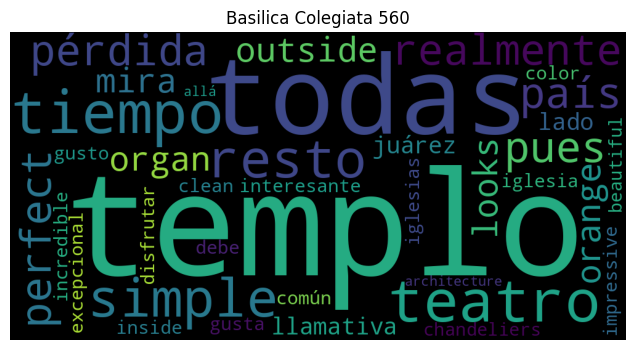

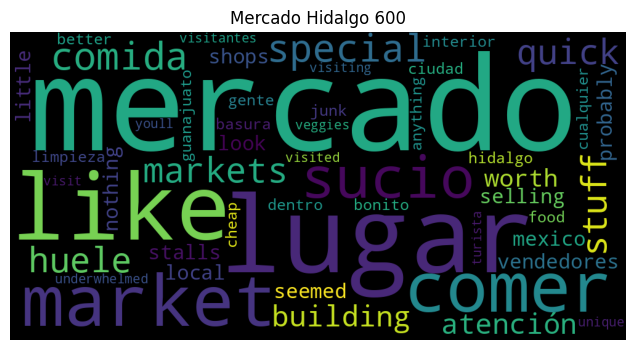

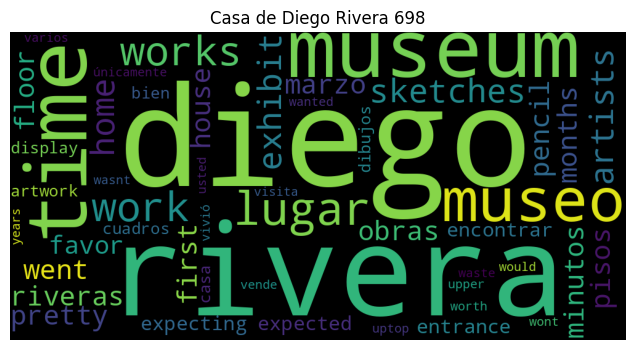

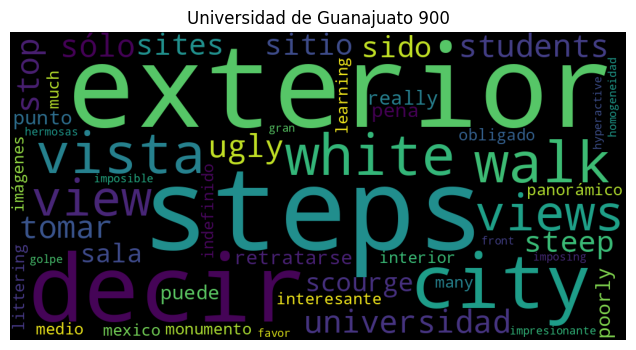

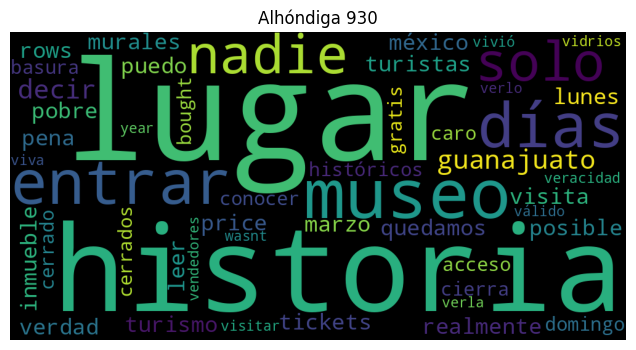

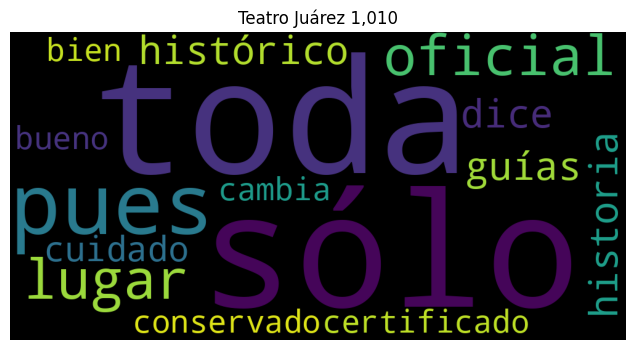

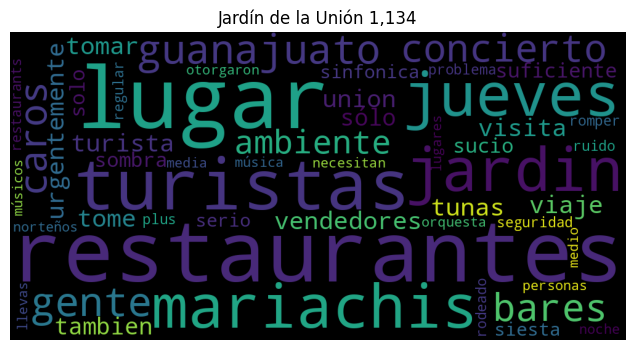

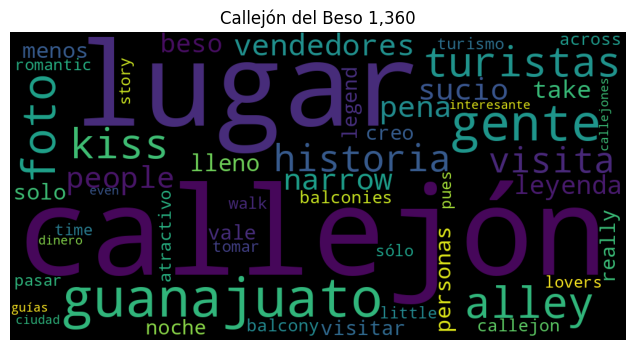

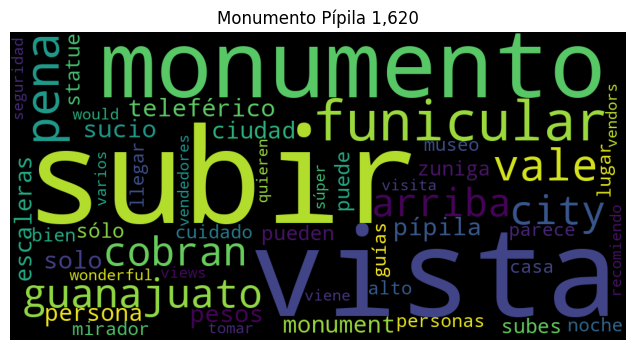

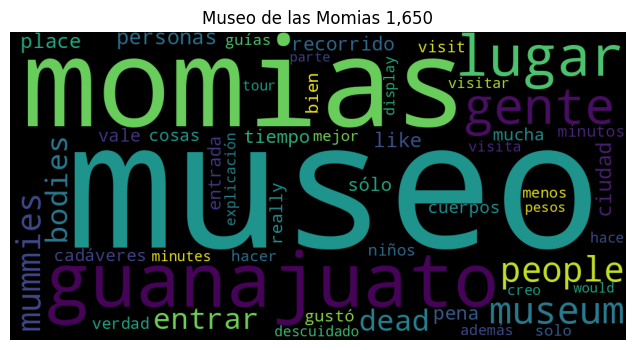

In [29]:
for s in sheets:
  z = get_opiniones(s)
  Nube(z,s)

# Bolsas de Palabras (15 pts)

In [36]:
def preparar_opiniones(s):
  df = pd.DataFrame(pd.read_excel(path,sheet_name=s))
  reviews = df['Opinión'].tolist()
  reviews = limpiar_corpus(reviews)
  t1,tm1 = unigramas(reviews)
  t2,tm2 = bigramas(reviews)
  t3,tm3 = trigramas(reviews)
  conc = hstack([tm1.multiply(t1.idf_),tm2.multiply(t2.idf_),tm3.multiply(t3.idf_)]).tocsc()
  return conc,df,t1,t2,t3

def trigramas(rvs):
  trigrama_tfidf = TfidfVectorizer(stop_words=stwrds,ngram_range=(3,3),max_features=1000)
  rvs_tfidf = trigrama_tfidf.fit_transform(rvs)
  return trigrama_tfidf,rvs_tfidf

def bigramas(rvs):
  #2000 bigramas con mayor peso tfidf
  bigrama_tfidf = TfidfVectorizer(stop_words=stwrds,ngram_range=(2,2),max_features=2000)
  rvs_tfidf = bigrama_tfidf.fit_transform(rvs)
  return bigrama_tfidf,rvs_tfidf

def unigramas(rvs):
  #creamos bolsa de palabras
  tfidf = TfidfVectorizer(stop_words=stwrds,max_features=1000,ngram_range=(1,1))
  rvs_tfidf = tfidf.fit_transform(rvs)
  return tfidf,rvs_tfidf

def ganancia(conc,df):
  selector = SelectKBest(chi2,k=1000)
  conc_mat = selector.fit_transform(conc,df['Opinión'])
  top1000 = selector.get_support(indices=True)
  return top1000

def get_relevantes(t1,t2,t3,top1000):
  palabras_rel = []
  for i in top1000:
    if i < 1000:
      palabras_rel.append(t1.get_feature_names_out()[i])
    elif i < 3000:
      palabras_rel.append(t2.get_feature_names_out()[i-1000])
    else:
      palabras_rel.append(t3.get_feature_names_out()[i-3000])

  return palabras_rel

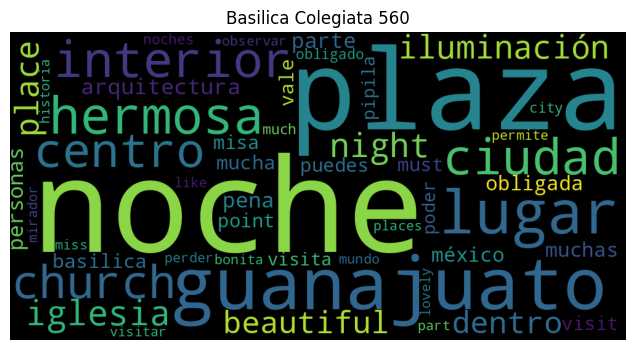

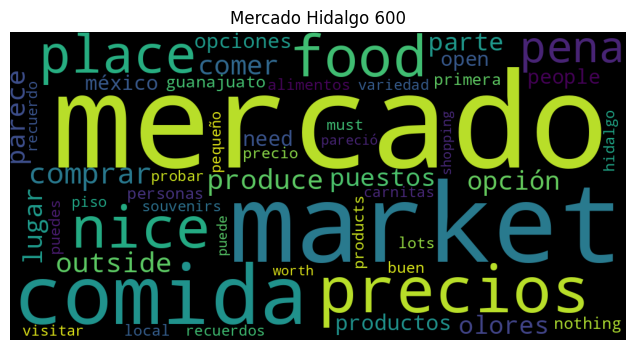

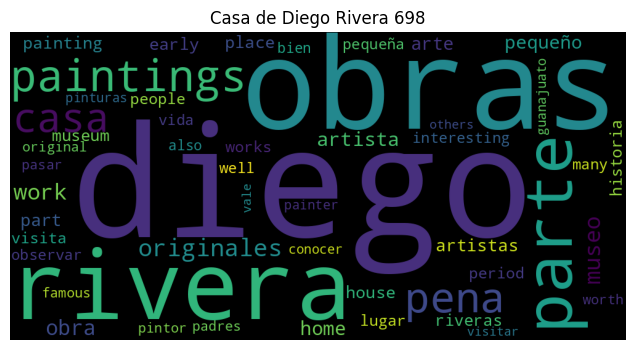

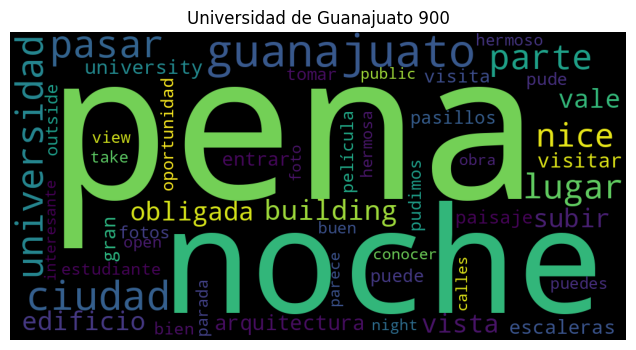

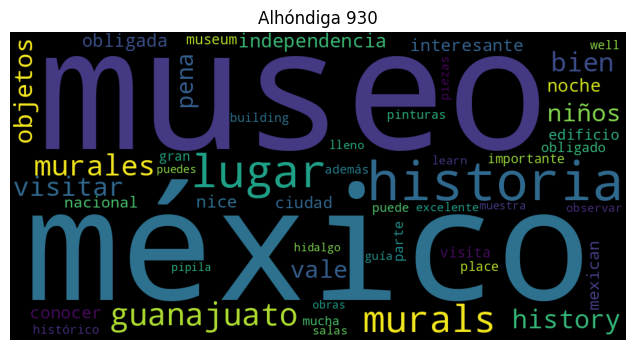

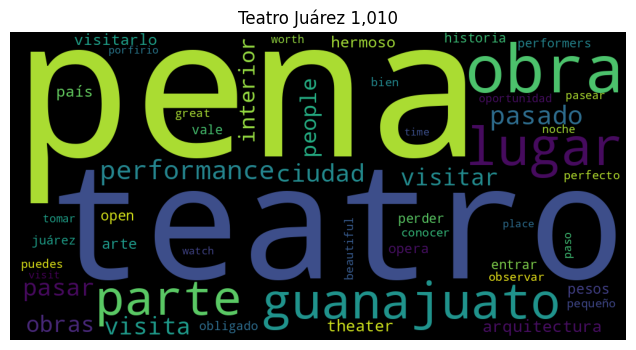

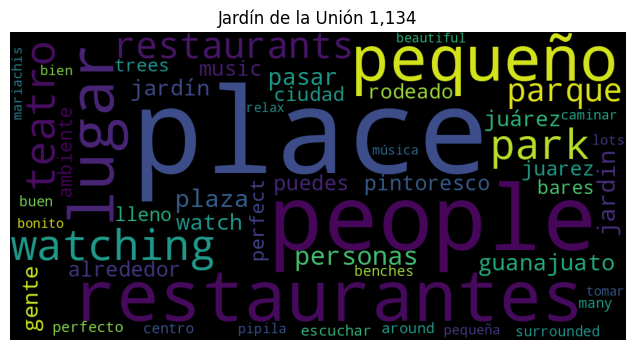

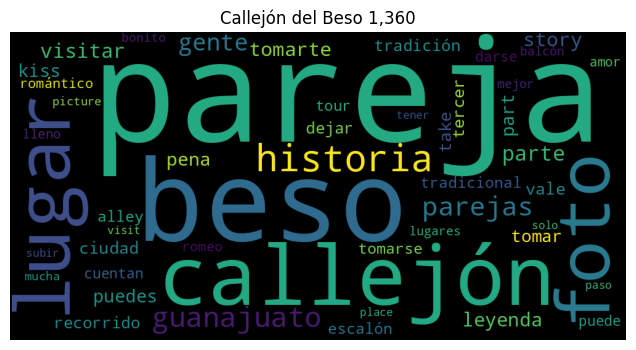

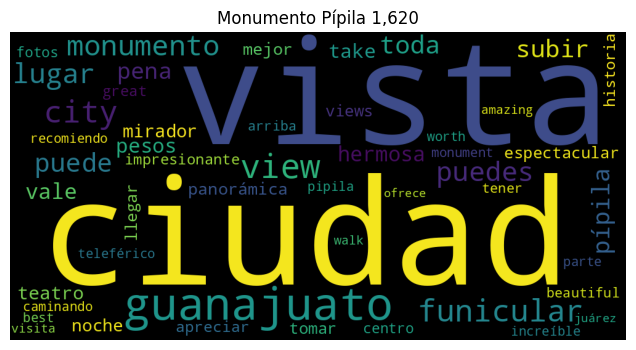

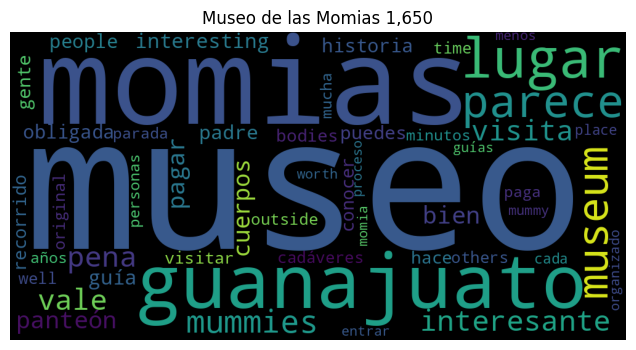

In [37]:
for s in sheets:
  conc,df,t1,t2,t3 = preparar_opiniones(s)
  g = ganancia(conc,df)
  rel = get_relevantes(t1,t2,t3,g)
  tops = obtener_top50(rel)
  Nube(tops,s)

# Linea del tiempo (10 pts)
Análisis temporal (formato libre) que muestre opiniones positivas, negativas y neutras a través de los meses y años para todos los sitios turísticos. En pocas palabras mostrar la evolución de las opiniones a través del tiempo.

In [38]:
def get_fechas(df):
  cps_d = {}
  for element in range(len(df)):
    fecha = df.at[element,"Fecha"]
    format_fecha = fecha.strftime('%Y/%m')
    #cps.append((format_fecha,df.at[element,"Opinión"]))
    if format_fecha not in cps_d.keys():
      escala = df.at[element,'Escala']
      if escala <= 2:
        val = [1,0,0]
      elif escala == 3:
        val = [0,1,0]
      elif escala > 3:
        val = [0,0,1]
      cps_d.update({format_fecha:val})
    else:
      escala = df.at[element,'Escala']
      if escala <= 2:
        cps_d[format_fecha][0] += 1
      elif escala == 3:
        cps_d[format_fecha][1] += 1
      elif escala > 3:
        cps_d[format_fecha][2] += 1
  cps_d = OrderedDict(sorted(cps_d.items()))
  return cps_d


def get_date_corpus(s):
  df = pd.DataFrame(pd.read_excel(path,sheet_name=s))
  cps = get_fechas(df)
  return cps

def plot_dates(y,s):
  keys_d = y.keys()
  pos = []
  neu = []
  neg = []
  for val in y.values():
    neg.append(val[0])
    neu.append(val[1])
    pos.append(val[2])

  plt.figure(figsize=(8,8))
  plt.plot(keys_d, pos,'b', label = "Positivos",linestyle=":")
  plt.plot(keys_d, neu,'y', label = 'Neutros',linestyle="--")
  plt.plot(keys_d, neg,'r', label = 'Negativos',linestyle="-.")
  plt.ylim(-5,50)
  plt.title(s)
  plt.xticks(rotation=75,fontsize=5)
  plt.legend()
  plt.show()


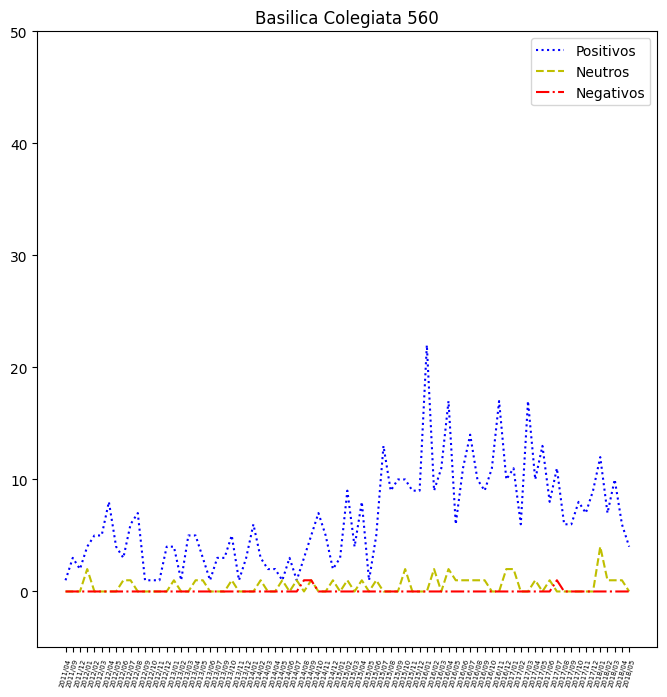

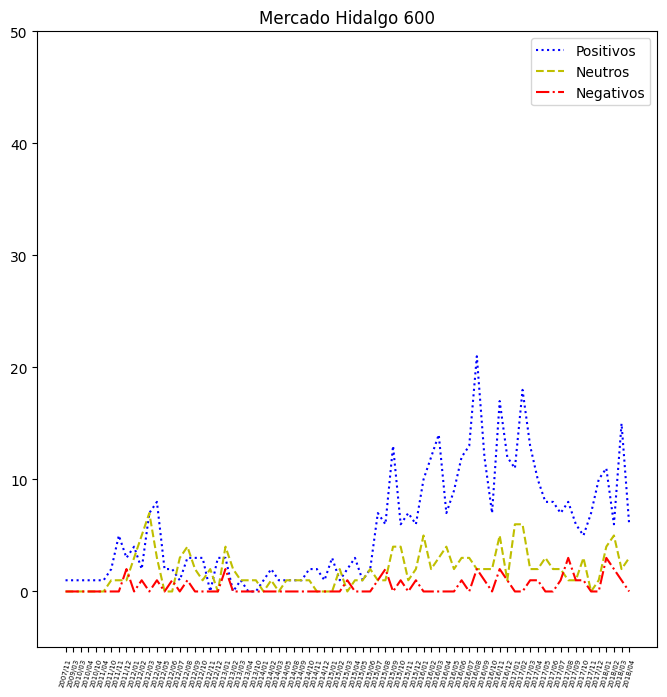

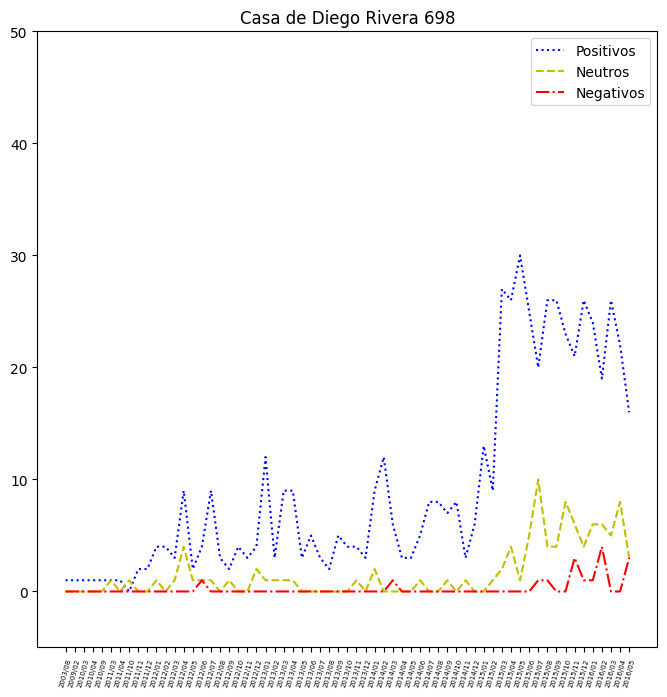

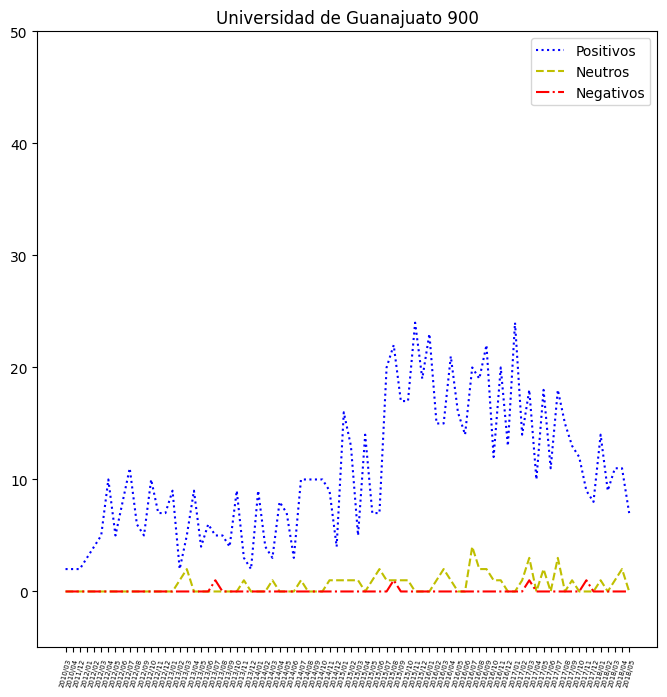

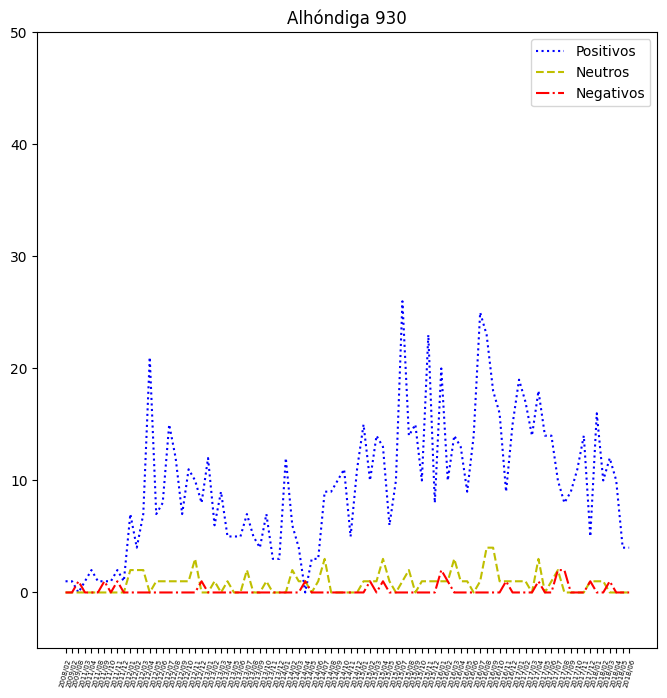

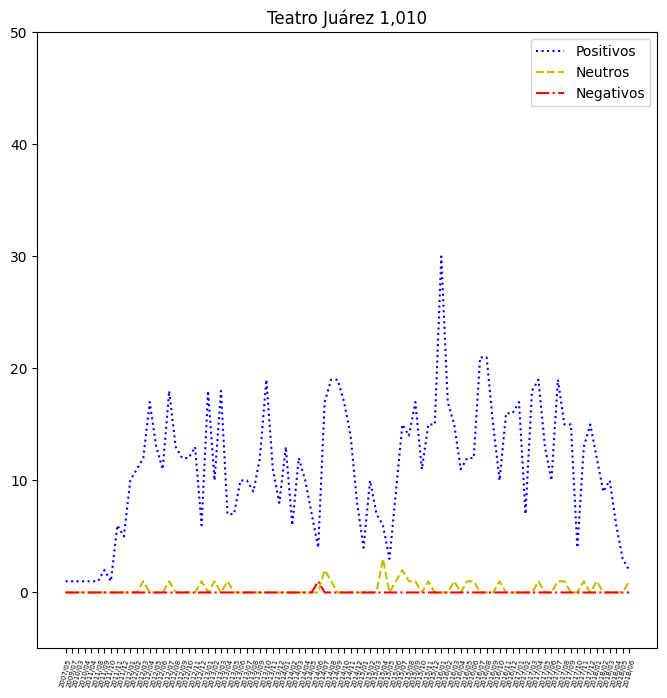

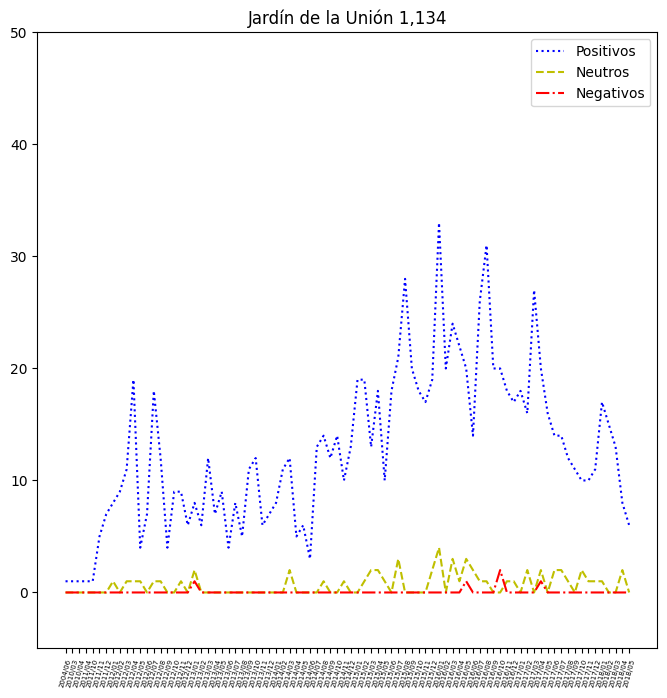

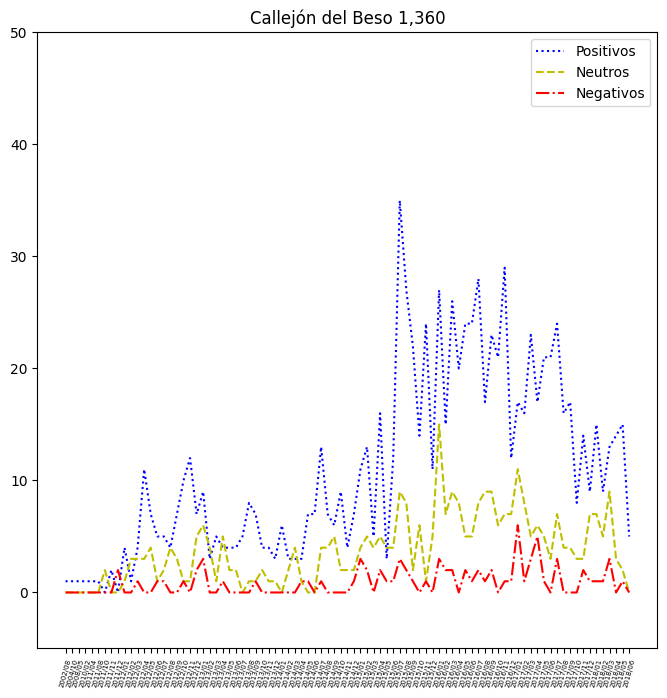

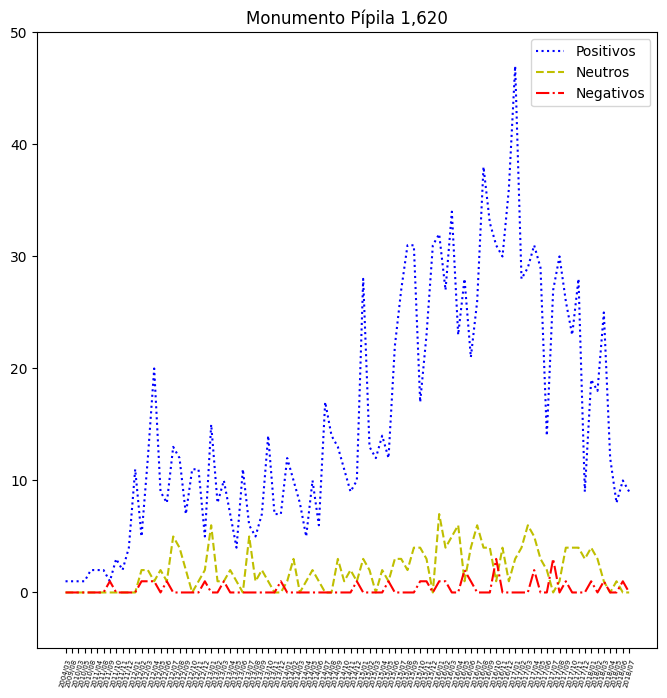

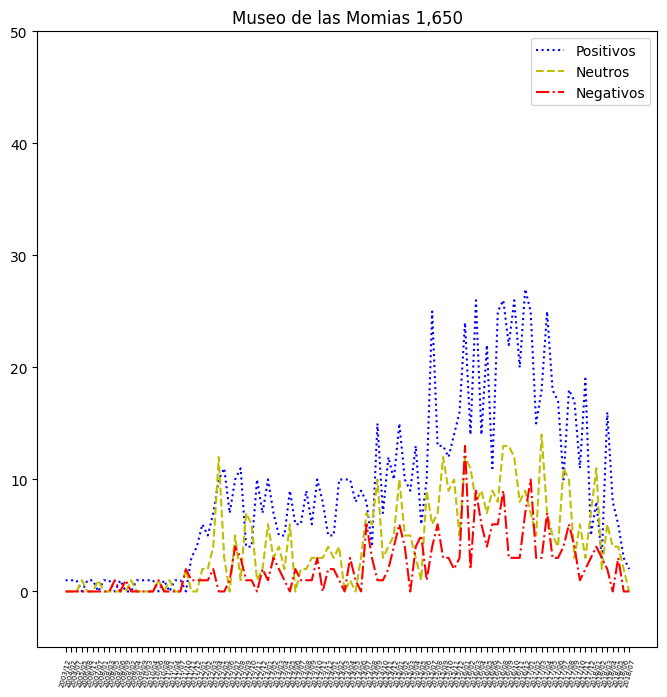

In [39]:
for s in sheets:
  y = get_date_corpus(s)
  plot_dates(y,s)

# Preguntas (50 pts)

1. (10 pts) ¿De los sitios turísticos, cuál diría usted que es el más polémico y la **razón de ello**?
2. (10 pts) En cuanto al sitio más polémico, ¿cómo es la diferencia de opinión y temas entre turistas nacionales e internacionales?
3. (10 pts) ¿Cuál diría que es el sitio que le gusta más a las mujeres y por qué?
4. (10 pts) ¿Cuál es el sitio que le gusta más a las personas jóvenes y por qué?
5. (10 pts) ¿Qué otras observaciones valiosas puede obtener de su análisis? (e.g., ¿identificó de qué se queja la gente?¿qué tipo de cosas le gustó a la gente?, etc.)

### 1. Sitio más polémico
Considerando los datos analizados en el proyecto, considero que el **Teatro Juárez** es el más polémico o aceptado. Primeramente, al hacer el análisis exploratorio, fue el lugar con una puntuación promedio de 4.7 de 5 (siendo la mejor evaluada) y el lugar con menor desviación estándar en cuanto a sus calificaciones (0.52). También, es un lugar que es concurrido principalmente por personas entre 30 y 40 años. Por otro lado, al momento de hacer la nube de palabras de palabras negativas, fue la nube con menor cantidad de palabras en ese contexto. Además, en cuestión de su calificación conforme pasa el tiempo, se puede observar que es uno de los sitios que muestra un leve cambio en cuanto a sus opiniones negativas y neutras a través del tiempo, y que tiene muchas opiniones positivas. Finalmente, en su evaluación con LSA, tanto hombres como mujeres, nacionales e internacionales, jóvenes y mayores, coinciden en que la arquitectura del teatro en el exterior e interior es hermosa y es un lugar que vale la pena visitar.

Palabras = 173

### 2. Nacionales vs Internacionales
De acuerdo a los datos observados arriba, este sitio es visitado mayormente por turistas nacionales (aproximadamente 600 personas) que por los turistas internacionales (aproximadamente 400 personas). Esto quiere decir que hay una diferencia aproximadamente del 20% entre turistas nacionales e internacionales que acuden a visitar al teatro. En cuanto a su descubrimiento de tópicos LSA, los nacionales coinciden que es un lugar hermoso en la ciudad de Guanajuato por estar lleno de historia y que vale la pena visitar. Por el contrario, los internacionales hacen más alusión a su arquitectura tanto externa como interna y que también vale la pena visitar ya sea durante el día o la noche. Esto quiere decir que para los nacionales, los tópicos principales del lugar tienen que ver con su historia principalmente (ya que es lo que usualmente se sabe) y los tópicos de los internacionales tienen que ver con la arquitectura del mismo.

Palabras = 150

### 3. Sitio de mujeres
Primeramente, considerando los datos del análisis exploratorio, en cuanto al número de opiniones dadas por lugar (divididos por género), el lugar más "criticado" por las mujeres es nada más y nada menos que el **callejón del beso**, con un porcentaje de 50.15% de las opiniones totales dadas para ese lugar. El callejón está apenas 0.15% por encima de la Casa de Diego Rivera, en el cual ambos hombres y mujeres dieron la misma cantidad de evaluaciones. Esto es lógico, pues los tópicos que se le atribuyen al callejón hacen alusión a fotos, parejas, besos, amor y romanticismo. En cuanto a la Casa de Diego Rivera, los tópicos de las mujeres en el lugar son acerca de arte, pinturas y casa. Esto quiere decir, que las mujeres se sienten más atraídas a lugares con leyendas de amor y romanticismo, o llenos de obras de arte. Sin embargo, las aportaciones de las mujeres para los 10 lugares tratados en este proyecto van desde el 43.4% al 50.15% del total de aportaciones críticas. 

Palabras=173


### 4. Sitio para jóvenes
Para este proyecto, se consideró como jóvenes a las personas con edad menor o igual a 35 años. Es verdad que al observar los gráficos por edad de cada uno de los lugares, predomina la cantidad de jóvenes. Sin embargo, los lugares en donde es notoria la asistencia de jóvenes son el Monumento al Pípila (con una asistencia predominante entre los 20 y 31 años principalmente en jóvenes), el Callejón del Beso (con asistencia predominante entre los 20 y 30 años), el Jardín de la Unión (con asistencia predominante entre los 25 y 33 años), el Museo de las Momias (con asistencia predominante entre los 25 y 30 años), al final la Universidad y el Mercado, en orden. De acuerdo con los tópicos de los jóvenes para estos lugares, lo que los jóvenes buscan es un lugar 1) con buen precio (a la mejor porque algunos no trabajan o ganan no mucho), 2) un lugar para tomarse foros, 3) lugares con vistas bonitas y 4) lugares para divertirse y disfrutar. Por ende, según esto, el **top 3** lugares para jóvenes son el Monumento al Pípila (por la vista), el Callejón del beso (por la foto típica), y el Jardín (por el ambiente con música y restaurantes, bonito y para disfrutar).

Palabras=210

### 5. Observaciones extra

Primero me gustaría enfocarme en lo que le molesta a la gente, o hace que los lugares tengan calificación negativa. De las palabras principales de las opiniones negativas que identifiqué, las top son:

1.   Pérdida de tiempo
2.   Suciedad, mal holor y basura
3.   Precio caro
4.   Descuido de los lugares
5.   Ruido

Ahora, los lugares que más visitan las personas internacionales son:
1. El Callejón del Beso (con una diferencia alrededor de 300 turistas con los nacionales)
2. La Alhóndiga (con una diferencia similar a la del Callejón)
3. La Universidad (con una diferencia similar a la del Callejón también)

Para cada uno de los lugares, de acuerdo a sus nubes de palabras, tópicos y features principales, las palabras que los describen a cada uno son las siguientes:
1. Basílica Colegiata: iglesia, arquitectura y hermosa
2. Mercado Hidalgo: comida, souvenirs y artesanías
3. Casa de Diego Rivera: museo, obras y arte
4. Universidad de Gto: Universidad, edificio y escalinatas
5. Alhóndiga: historia, independencia y murales
6. Teatro Juárez: teatro, historia y arquitectura
7. Jardín de la Unión: restaurantes, música y bares
8. Callejón del Beso: foto, beso y romántico
9. Monumentó al Pípila: vista, funicular y mirador
10. Museo de las momias: momias, cuerpos e historia

Esto nos puede decir que sí está identificando las principales características de cada lugar, ya que sí están muy relacionadas con el lugar.

Palabras=230


